In [3]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



/var/folders/yl/gn9fldpj69169vhn466y4klh0000gn/T/ipykernel_77868/1641688.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,start='2000-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,
2021-11-12,441.753815,442.311593,438.766369,439.721225,53466700,440.943926,2.357582e+10,2.357582e+10,0.000000e+00,76.223874,-1.0,NaN,NaN
2021-11-15,441.905060,443.209707,440.770605,443.049006,46980500,441.961791,2.076359e+10,0.000000e+00,2.076359e+10,69.819038,-1.0,0.000342,-0.000342
2021-11-16,443.654083,444.798001,441.564773,441.640391,48857500,443.338952,2.166043e+10,2.166043e+10,0.000000e+00,68.943677,0.0,0.004302,-0.000342
2021-11-17,442.576324,443.568976,441.952362,443.389349,47858300,442.699221,2.118683e+10,0.000000e+00,2.118683e+10,69.166630,0.0,0.001862,-0.000342
2021-11-18,444.079468,444.344177,440.874572,443.616206,50625600,443.099405,2.243217e+10,2.243217e+10,0.000000e+00,68.396384,0.0,0.005265,-0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-13,663.039978,665.130005,659.770020,660.650024,79560500,662.646667,5.272050e+10,0.000000e+00,5.272050e+10,57.176229,0.0,0.500926,-0.023678
2025-10-14,662.229980,665.830017,653.169983,657.169983,88779600,660.409993,5.863094e+10,5.863094e+10,0.000000e+00,64.131925,0.0,0.499093,-0.023678
2025-10-15,665.169983,670.229980,658.929993,666.820007,81702600,664.776652,5.431398e+10,0.000000e+00,5.431398e+10,56.431578,0.0,0.505748,-0.023678


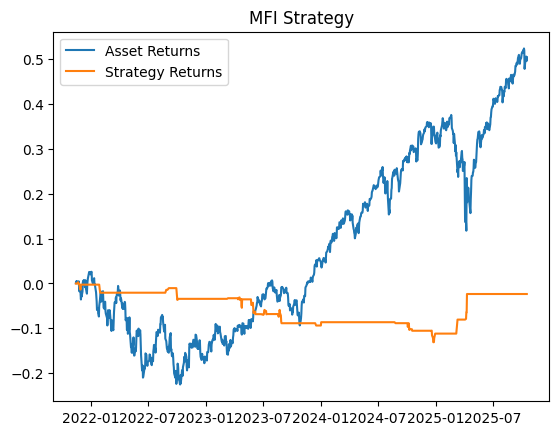

In [18]:
TICKER = 'SPY'
MFI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000

def get_data(ticker=TICKER):
    df=yf.download(ticker,start='2000-01-01')
    df.columns = df.columns.get_level_values(0)
    
    #only return the usbset of data interested in
    return df.iloc[-LOOKBACK:,:]

def add_MFI(df, length=MFI_LENGTH):
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) /3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
    
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0
    
    df['Pos_Flow'] = np.where(df['Money_Flow'].diff() > 0, df['Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Money_Flow'].diff() < 0, df['Money_Flow'], 0)
    
    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()
    #add money flow column
    df['MFI'] = 100 - (100/(1 + mfr))
    return df.dropna()

def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):
    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI'] > overbought, -1,
                     np.where(df['MFI'] < oversold, 1, 0))
    df['Strategy'] = df['Strategy'].shift(1)
    return df.dropna()

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1
    
    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.title('MFI Strategy')
    plt.legend(['Asset Returns', 'Strategy Returns'])
    return df


def main():
    df = get_data(TICKER)
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    
    return df

df=main() 
df

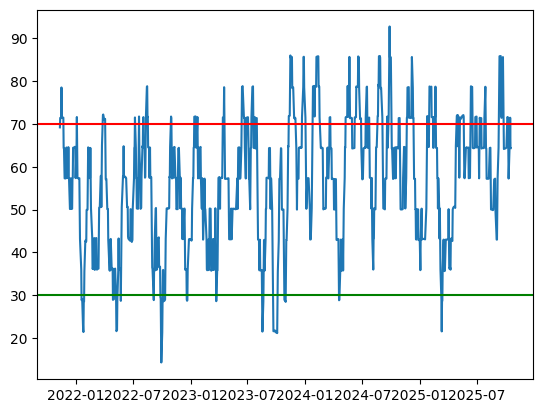

In [11]:
plt.plot(df['MFI'])
plt.axhline(OVERBOUGHT, color='red')
plt.axhline(OVERSOLD, color='green')
